In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
sns.set_style('white')
sns.set(rc={'figure.figsize': (11, 4)})

## 1.

In [3]:
# dummy dataset
DF_ORIG = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv', index_col='timestamp', parse_dates=True)
# DF_ORIG = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_IBM.csv', index_col='timestamp', parse_dates=True)

In [4]:
DF_ORIG.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


In [5]:
DF_ORIG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15831 entries, 2015-02-26 21:42:53 to 2015-04-22 20:52:53
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   15831 non-null  int64
dtypes: int64(1)
memory usage: 247.4 KB


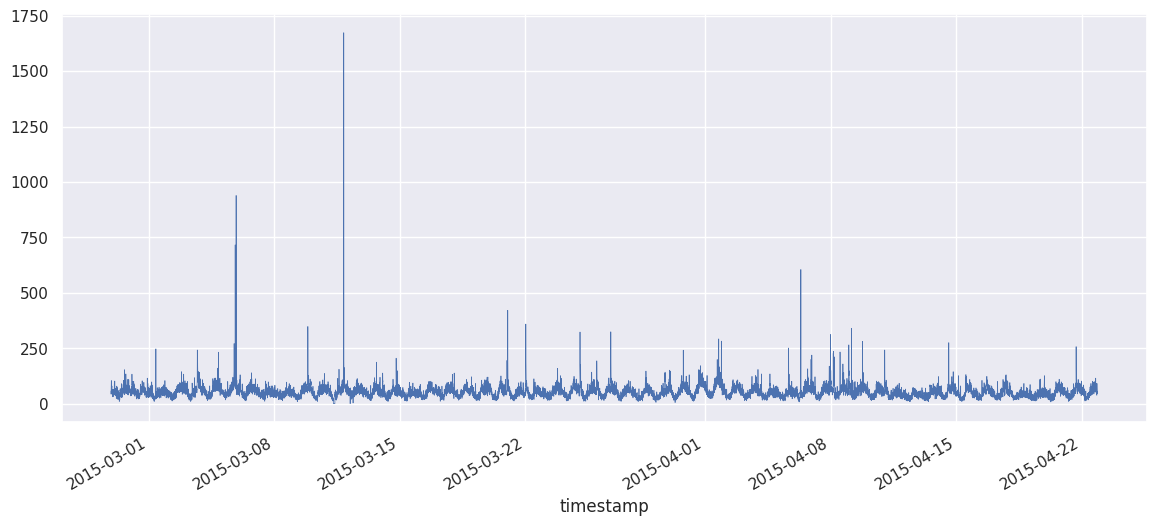

In [6]:
plt.figure(figsize=(14, 6))
DF_ORIG['value'].plot(linewidth=0.5)
plt.show()

In [7]:
DF_ORIG['date'] = pd.to_datetime(DF_ORIG.index).date

In [8]:
DF_ORIG['h'] = pd.to_datetime(DF_ORIG.index).hour

In [9]:
DF_ORIG.head(1)

,value,date,h
timestamp,,,
2015-02-26 21:42:53,57,2015-02-26,21


In [10]:
df_date = DF_ORIG.groupby('date').sum()

### TODO: chance that i must drop outliers

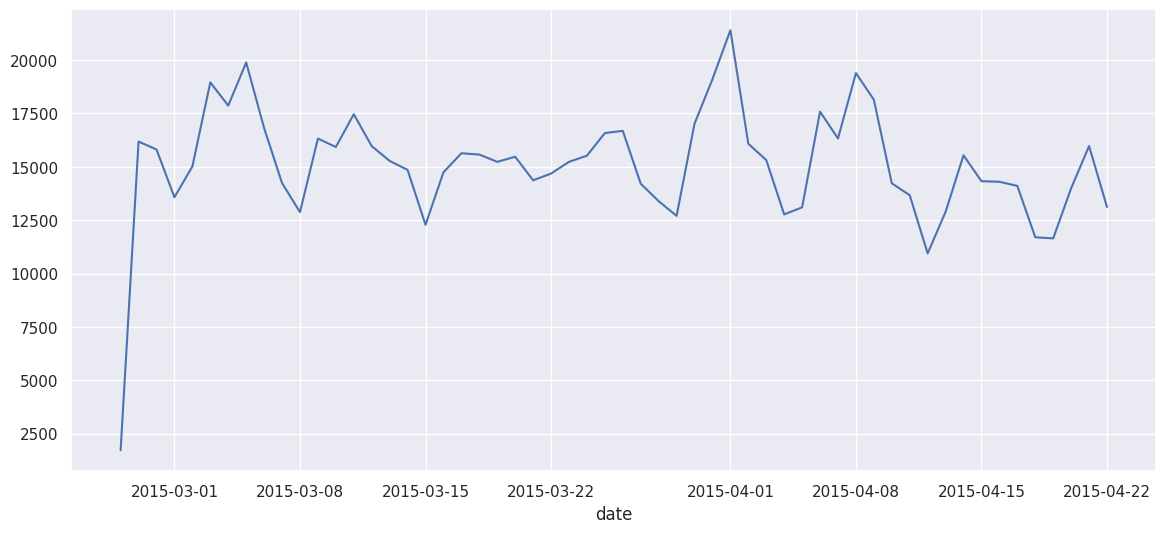

In [11]:
plt.figure(figsize=(14, 6))
df_date['value'].plot()
plt.show()

In [12]:
df_h = DF_ORIG.groupby(pd.Grouper(freq='1h')).sum(numeric_only=True)
df_h.head(5)

,value,h
timestamp,,
2015-02-26 21:00:00,219,84
2015-02-26 22:00:00,931,264
2015-02-26 23:00:00,568,276
2015-02-27 00:00:00,516,0
2015-02-27 01:00:00,574,12


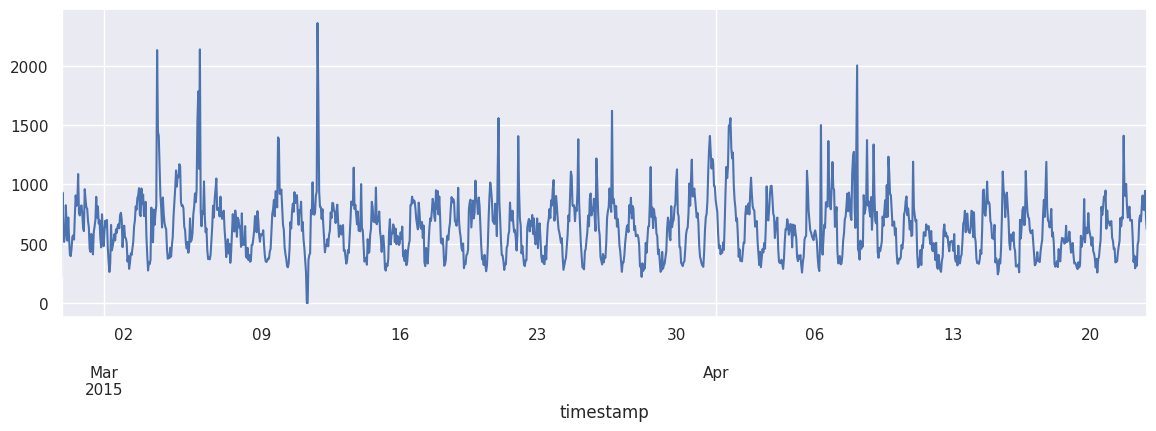

In [13]:
plt.figure(figsize=(14, 4))
df_h['value'].plot()
plt.show()

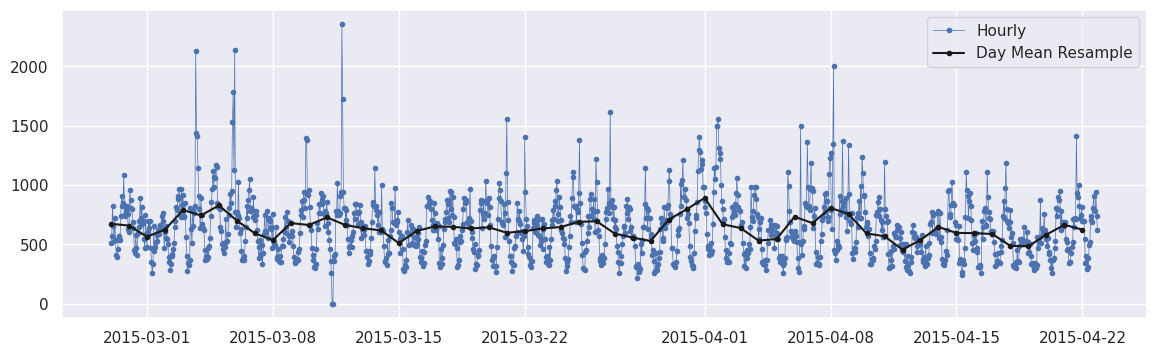

In [14]:
start, end = '2015-02-27', '2015-04-22'

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_h.loc[start:end, 'value'],marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(df_h.resample('D').mean().loc[start:end, 'value'], marker='o',
        markersize=3, linestyle='-', label='Day Mean Resample', color='k')
ax.legend();

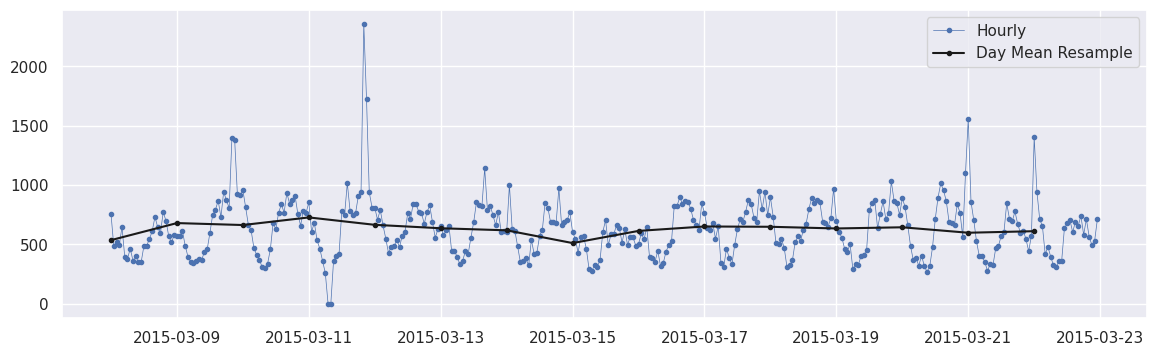

In [15]:
start, end = '2015-03-08', '2015-03-22'

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_h.loc[start:end, 'value'],marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(df_h.resample('D').mean().loc[start:end, 'value'], marker='o', markersize=3, linestyle='-', label='Day Mean Resample', color='k')
ax.legend();

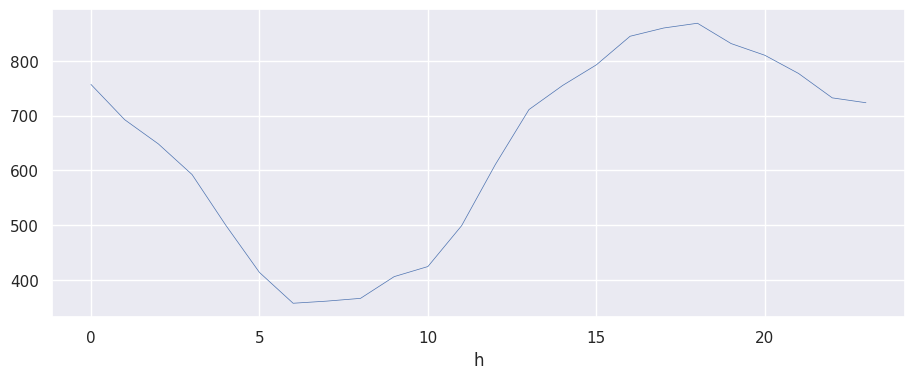

In [16]:
df_h.h = pd.to_datetime(df_h.index).hour

df_h_h = df_h.groupby('h').mean()

df_h_h['value'].plot(linewidth=0.5)
plt.show()

## 2.

In [18]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 12.3 MB/s eta 0:00:00


### TODO: simplify imports

In [30]:
import warnings
import sktime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tools.sm_exceptions import ConvergenceWarning

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [23]:
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)

r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

%matplotlib inline

In [25]:
df_h_copy = df_h.value.astype('float')

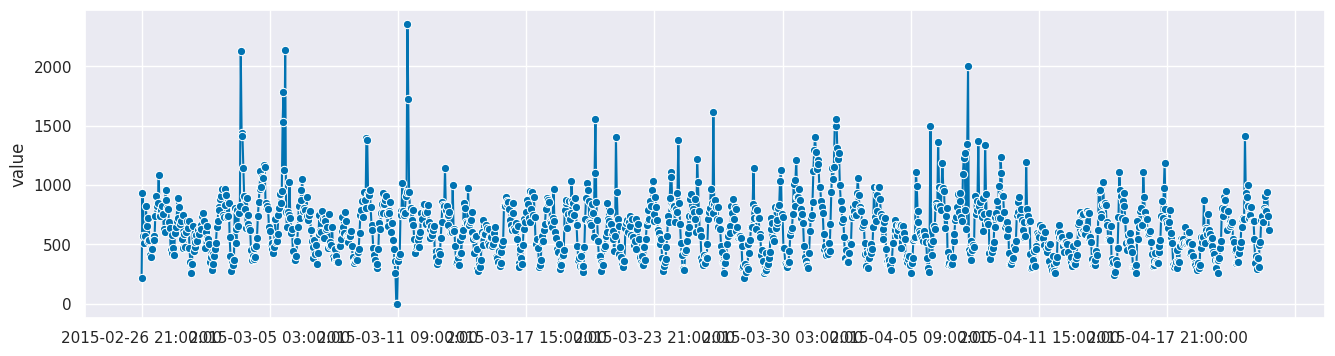

In [29]:
sktime.utils.plotting.plot_series(df_h_copy)
plt.show()

In [44]:
X_train, X_test = temporal_train_test_split(df_h_copy, test_size=int(df_h_copy.size * 0.4))

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

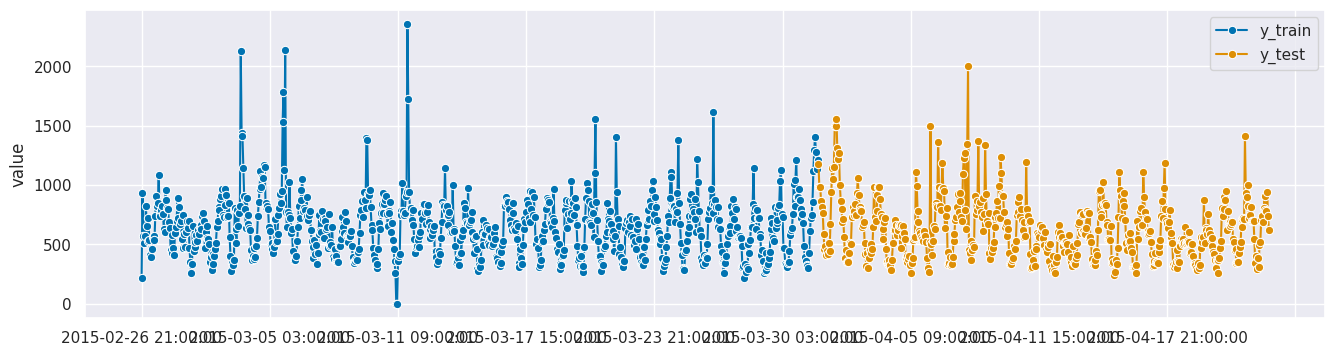

In [45]:
sktime.utils.plotting.plot_series(X_train, X_test, labels=['y_train', 'y_test'])

In [46]:
# X_train.to_csv("X_train.csv", index_label="timestamp")
# X_test.to_csv("X_test.csv", index_label="timestamp")
# df_h.to_csv("df_h.csv", index_label="timestamp")

### TODO: change these values

In [47]:
for i in range(len(X_train)):
    if X_train[i] > 1400:
        X_train[i] = 1400
    if X_train[i] < 250:
        X_train[i] = 250

In [52]:
FH = ForecastingHorizon(X_test.index, is_relative=False)

In [53]:
FORECASTER = NaiveForecaster(strategy="mean", sp=24)

In [54]:
FORECASTER.fit(X_train)

NaiveForecaster(sp=24, strategy='mean')

In [55]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

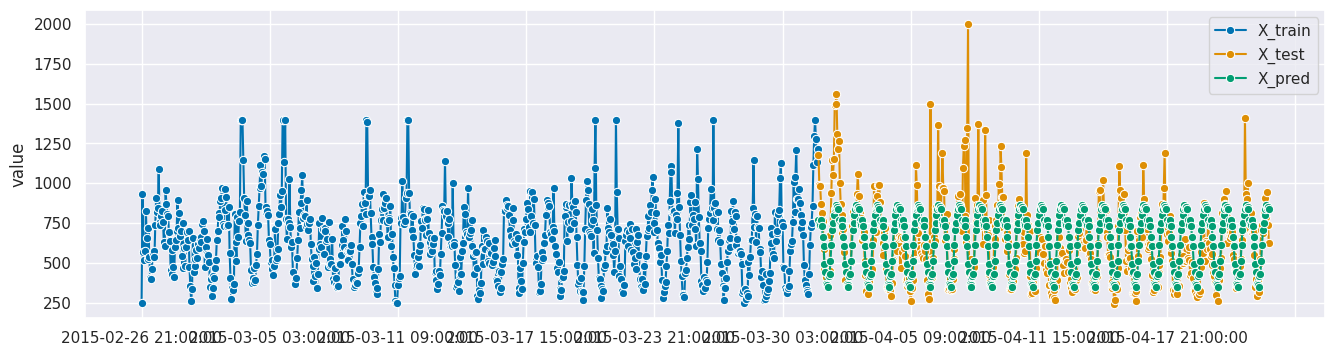

In [56]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])